<a href="https://colab.research.google.com/github/cstarke3/PY506-HW/blob/main/Starke_Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Schrödinger equation numerically


In [1]:
import numpy as np
from scipy import constants as const
from scipy import sparse as sparse
from scipy.sparse.linalg import eigs
from matplotlib import pyplot as plt
from scipy import linalg as la

### 0.5 Some constants and other parameters

In [2]:
N = 500 #Number of Trials

#Natural Units
hbar = 1
m = 1
a = .000000000001 #Value close to 0 to avoid divide by 0 errors
b = 18 #Three times outside the nuclear radius
A_ws = 50 #Wood Saxon A_ws potential
A_so = 0 #Spin Orbit A_so potential
R = 6 #Nuclear Radius (Becuse radii values and distance are inside and exponential the units drop out)
a_skin = 0.6 #skin radius
l = 0 #orbital angular momentum
s = 1/2 #spin angular momentum
j = l+s #total angular momentum
x = np.linspace(a,b,N)
Physical_Units = False


#Physical Units (Can comment out)
hbar = const.hbar
m = const.proton_mass
a = 1*(10**-18)
b = 18*(10**-15)
A_ws = 50*(10**6)*(1.602*10**-19)
R = 6*(10**-15)
a_skin = 0.6*(10**-15)
x = np.linspace(a,b,N)
conv = 6.242*(10**12)
Physical_Units = True

## Coefficients
C = -hbar**2/(2*m)
Delta = x[1] - x[0] #step sized defined by linspace operator

### 1. Build kinetic energy matrix

In [3]:
## The diagonal and off-diagonal terms
diag = -2 * np.ones(N)
offdiag = 1 * np.ones(N)

T_matrix = sparse.diags([diag, offdiag, offdiag], (0,-1,1))
print(T_matrix.todense())

[[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -2.]]


### 2. Potential enegy matrix
I'll assume a simple harmonic oscillator

In [4]:
## The definition of the potential
def WoodSaxon(x): #WoodSaxon Potential Function
  return -(A_ws/(1+np.exp((x-R)/a_skin)))

def SpinOrbit(x, A_so, j ,l ,s): #Spin Orbit Potential Function, including the quantum number ...l(l+1) as I am already passing in the l value
  return -(A_so/2)*(np.exp((x-R)/a_skin)/(1+np.exp((x-R)/a_skin))**2)*(j*(j+1)-l*(l+1)-s*(s+1)) + (hbar**2/(2*m*x**2))*(l*(l+1))

diag_WS = WoodSaxon(x) #Combining Wood Saxon and Spin Orbit Functions
diag_SO = SpinOrbit(x, A_so, j, l, s)
WS_matrix = sparse.diags(diag_WS,0)
SO_matrix = sparse.diags(diag_SO,0)


V_matrix = np.add(WS_matrix,SO_matrix)


### 3. Make the hamiltonian

In [5]:
H = np.identity(N)*(-(hbar**2/(2*m*(Delta**2)))*T_matrix +  V_matrix) #Combining T and V matrices into the Hamiltonian, transforming to a numpy matrix
#H[0] = 0
#H[-1] = 0 #setting values at 0 and far from the nuclear radii to 0
H = np.delete(H, 0, 0)
H = np.delete(H, -1, 0)
H = np.delete(H, 0, 1)
H = np.delete(H, -1, 1)
print(H)
print(H.shape)

[[ 5.10243722e-09 -2.55522342e-09  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.55522342e-09  5.10243724e-09 -2.55522342e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.55522342e-09  5.10243727e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.11044683e-09
  -2.55522342e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.55522342e-09
   5.11044683e-09 -2.55522342e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -2.55522342e-09  5.11044683e-09]]
(498, 498)


### 4. Solve!

Here we use the sparse-matrix "eigs" function. Then we make sure everything is in order and print the energies

In [6]:
l = 0 #redifining l and j here for clarity, s remains 1/2
j = l+s


A_so = 0
diag_WS = WoodSaxon(x)
diag_SO = SpinOrbit(x, A_so, l+s, l, s)
WS_matrix = sparse.diags(diag_WS,0)
SO_matrix = sparse.diags(diag_SO,0)
V_matrix = np.add(WS_matrix,SO_matrix)
H = np.identity(N)*(-(hbar**2/(2*m*Delta**2))*T_matrix + V_matrix)
H = np.delete(H, 0, 0)
H = np.delete(H, -1, 0)
H = np.delete(H, 0, 1)
H = np.delete(H, -1, 1)
eval, evec1 = la.eig(H) #finding energy eignvalues here

z = np.argsort(eval)
z = z[0:10]
#energies = (eval[z]/eval[z][0])
energies = eval[z]


if Physical_Units == True:
  energies = energies*conv
  eval = eval*conv

eval1 = [] #steps from line 24 to 53 filter unbound states and attempts to identify unique eigenvalue solutions by filtering values within 2 MeV
vals = []  # of the first accepted value. 2 MeV was chosen as the first and smallest identifiable energy change from the Text Book
vals = eval.copy()


for i in range(len(vals)): #Truncates to three decimals
  eval1 = np.append(eval1, '%.3f'%(np.real(vals[i])))

vals = eval1.astype(float)

eval1 = []

for i in range(len(vals)): #drops unbound states
  if vals[i] < 0:
    eval1 = np.append(eval1, vals[i])

eval1 = np.sort(eval1)

if Physical_Units == False:
  vals = eval1.astype(float)
  eval1 = []
  i = 0

  for _ in range(len(vals)-1): #filters within 2 MeV
    for t in range(i+1, len(vals)):
      if np.absolute(vals[i])-np.absolute(vals[t]) > 2:
        eval1 = np.append(eval1, vals[i])
        i=t
        break

print(np.real(energies)) #Lowest 10 Eigenvalues
print(np.sort(eval1)) #"Unique" energy eigenvalues for l = 0

[-43.74686283 -28.35700961  -9.07078473   1.29132134   4.82468687
  10.21963453  17.40713455  26.26455526  36.57941156  48.23026956]
[-43.747 -28.357  -9.071]


In [7]:
l = 1 # Exact same steps as above method with l = 1
j = l+s


A_so = 0
diag_WS = WoodSaxon(x)
diag_SO = SpinOrbit(x, A_so, l+s, l, s)
WS_matrix = sparse.diags(diag_WS,0)
SO_matrix = sparse.diags(diag_SO,0)
V_matrix = np.add(WS_matrix,SO_matrix)

H = np.identity(N)*((-hbar**2/(2*m*Delta**2))*T_matrix + V_matrix)
H = np.delete(H, 0, 0)
H = np.delete(H, -1, 0)
H = np.delete(H, 0, 1)
H = np.delete(H, -1, 1)
eval, evec = la.eig(H)

z2 = np.argsort(eval)
z2 = z2[0:10]
#energies = (eval[z]/eval[z][0])
energies2 = eval[z2]

if Physical_Units == True:
  energies = energies*conv
  eval = eval*conv

eval2 = []
vals = []
vals = eval.copy()


for i in range(len(vals)):
  eval2 = np.append(eval2, '%.3f'%(np.real(vals[i])))

vals = eval2.astype(float)

eval2 = []

for i in range(len(vals)):
  if vals[i] < 0:
    eval2 = np.append(eval2, vals[i])

eval2 = np.sort(eval2)

if Physical_Units == False:
  vals = eval2.astype(float)
  eval2 = []
  i = 0

  for _ in range(len(vals)-1):
    for t in range(i+1, len(vals)):
      if np.absolute(vals[i])-np.absolute(vals[t]) > 2:
        eval2 = np.append(eval2, vals[i])
        i=t
        break

print(np.real(energies2))
print(np.sort(eval2))

[-6.05267605e-12 -3.10379899e-12 -1.68774301e-13  3.79645982e-13
  1.14691391e-12  2.20184171e-12  3.49242188e-12  5.00981975e-12
  6.75989337e-12  8.73432846e-12]
[-37.781 -19.374  -1.053]


In [8]:
l = 2 # Exact same methods as above with l = 2
j = l+s


A_so = 0
diag_WS = WoodSaxon(x)
diag_SO = SpinOrbit(x, A_so, l+s, l, s)
WS_matrix = sparse.diags(diag_WS,0)
SO_matrix = sparse.diags(diag_SO,0)
V_matrix = np.add(WS_matrix,SO_matrix)
H = np.identity(N)*((-hbar**2/(2*m*Delta**2))*T_matrix + V_matrix)
H = np.delete(H, 0, 0)
H = np.delete(H, -1, 0)
H = np.delete(H, 0, 1)
H = np.delete(H, -1, 1)
eval, evec = la.eig(H)

z3 = np.argsort(eval)
z3 = z3[0:10]
#energies = (eval[z]/eval[z][0])
energies3 = eval[z3]


if Physical_Units == True:
  energies = energies*conv
  eval = eval*conv

eval3 = []
vals = []
vals = eval.copy()


for i in range(len(vals)):
  eval3 = np.append(eval3, '%.3f'%(np.real(vals[i])))

vals = eval3.astype(float)

eval3 = []

for i in range(len(vals)):
  if vals[i] < 0:
    eval3 = np.append(eval3, vals[i])

eval3 = np.sort(eval3)

if Physical_Units == False:
  vals = eval3.astype(float)
  eval3 = []
  i = 0

  for _ in range(len(vals)-1):
    for t in range(i+1, len(vals)):
      if np.absolute(vals[i])-np.absolute(vals[t]) > 2:
        eval3 = np.append(eval3, vals[i])
        i=t
        break

print(np.real(energies3))
print(np.sort(eval3))

[-4.91735790e-12 -1.63719466e-12  3.38125848e-13  8.58469463e-13
  1.67617710e-12  2.81319179e-12  4.22370572e-12  5.86394183e-12
  7.71863882e-12  9.79051938e-12]
[-30.694 -10.219]


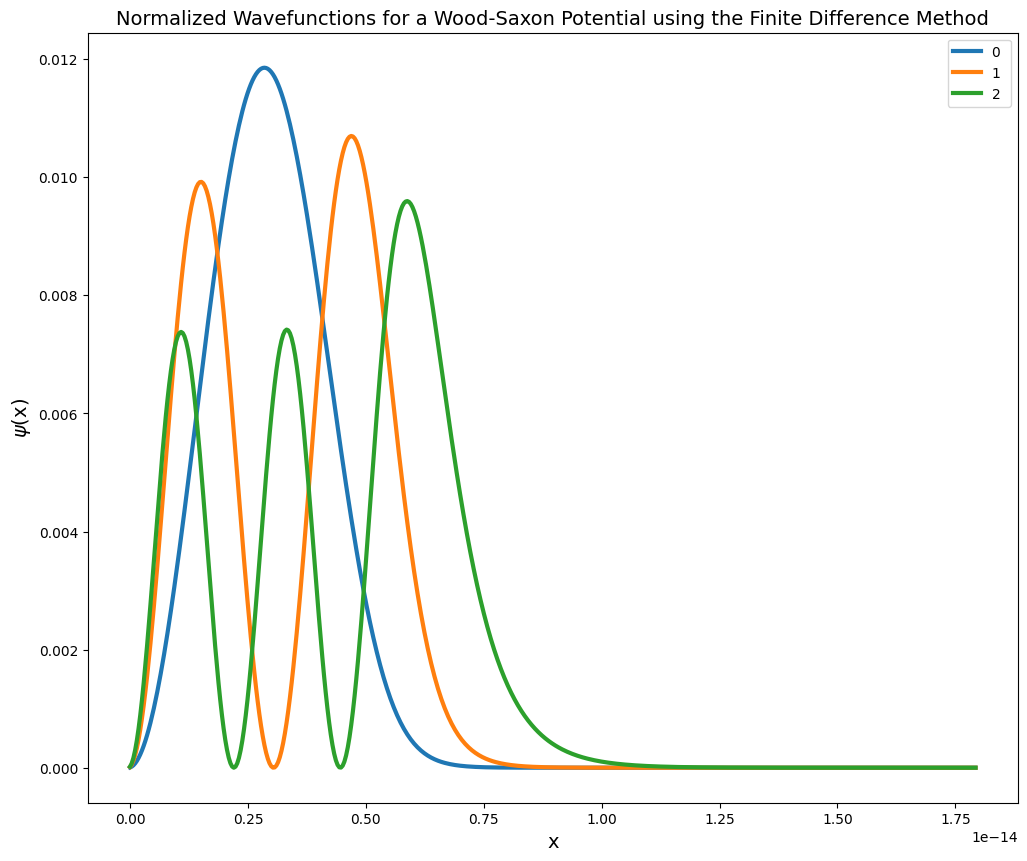

In [9]:
plt.figure(figsize=(12,10)) # Plots the l = 0 wave functions of the three lowest EigenVectors
for i in range(0, 3):
    y = []
    y = np.append(y,np.absolute(evec1[:,z[i]])**2)
    plt.plot(Delta*range(0,len(y)),y,lw=3, label="{} ".format(i))
    plt.xlabel('x', size=14)
    plt.ylabel('$\psi$(x)',size=14)
plt.legend()
plt.title('Normalized Wavefunctions for a Wood-Saxon Potential using the Finite Difference Method',size=14)
plt.show()

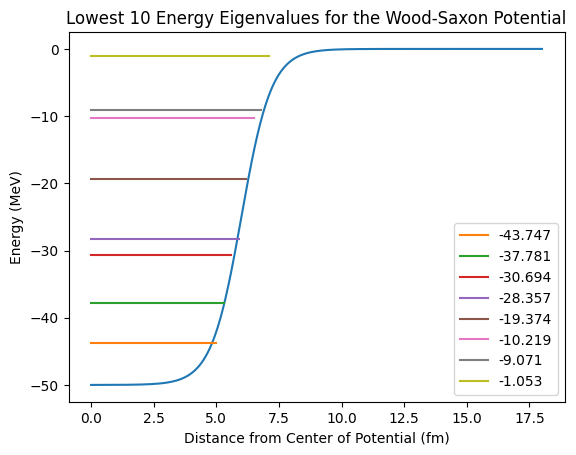

In [10]:
if Physical_Units == True:    #plots the 10 lowest energy eigen values against the WS potential
  plt.plot(x*10**15, WoodSaxon(x)*conv)
else:
  plt.plot(x, WoodSaxon(x))

energies = np.concatenate((eval1, eval2, eval3))
energies = np.sort(energies)

for i in range(0,len(energies)):
  plt.plot([0,(i*0.3+5)], [energies[i], energies[i]], label= energies[i])

#for i in range(0,len(eval2)):
#  plt.plot([0,6], [eval2[i], eval2[i]], label= eval2[i])

#for i in range(0,len(eval3)):
#  plt.plot([0,6], [eval3[i], eval3[i]], label= eval3[i])

plt.title("Lowest 10 Energy Eigenvalues for the Wood-Saxon Potential")
plt.xlabel("Distance from Center of Potential (fm)")
plt.ylabel("Energy (MeV)")
plt.legend()

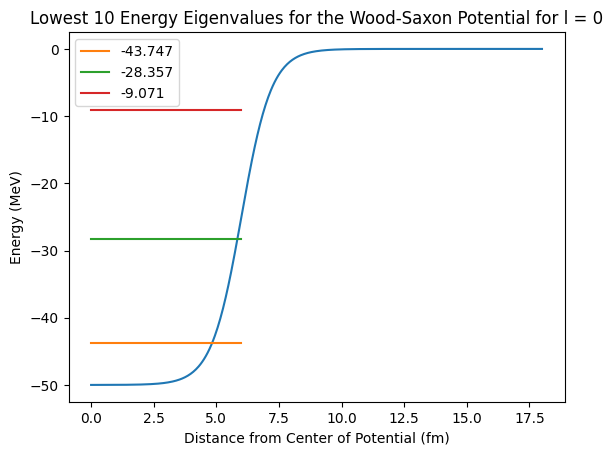

In [11]:
if Physical_Units == True:    #plots the 10 lowest energy eigen values against the WS potential
  plt.plot(x*10**15, WoodSaxon(x)*conv)
else:
  plt.plot(x, WoodSaxon(x))

for i in range(0,len(eval1)):
  plt.plot([0,6], [eval1[i], eval1[i]], label= eval1[i])
plt.title("Lowest 10 Energy Eigenvalues for the Wood-Saxon Potential for l = 0")
plt.xlabel("Distance from Center of Potential (fm)")
plt.ylabel("Energy (MeV)")
plt.legend()

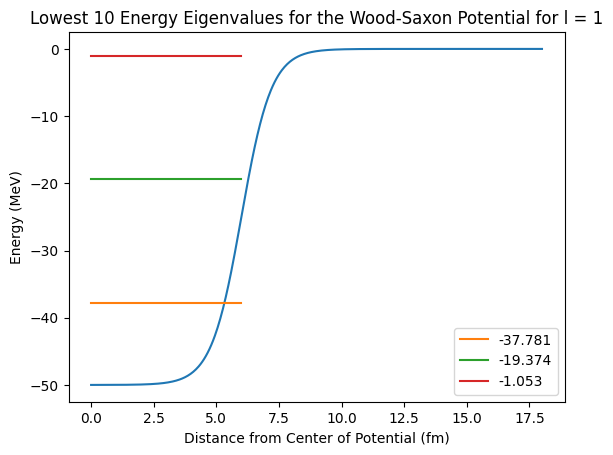

In [12]:
if Physical_Units == True:    #plots the 10 lowest energy eigen values against the WS potential
  plt.plot(x*10**15, WoodSaxon(x)*conv)
else:
  plt.plot(x, WoodSaxon(x))

for i in range(0,len(eval2)):
  plt.plot([0,6], [eval2[i], eval2[i]], label= eval2[i])
plt.title("Lowest 10 Energy Eigenvalues for the Wood-Saxon Potential for l = 1")
plt.xlabel("Distance from Center of Potential (fm)")
plt.ylabel("Energy (MeV)")
plt.legend()

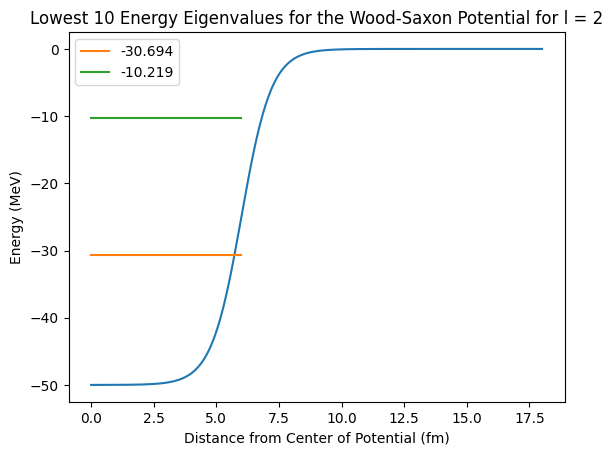

In [13]:
if Physical_Units == True:    #plots the 10 lowest energy eigen values against the WS potential
  plt.plot(x*10**15, WoodSaxon(x)*conv)
else:
  plt.plot(x, WoodSaxon(x))

for i in range(0,len(eval3)):
  plt.plot([0,6], [eval3[i], eval3[i]], label= eval3[i])
plt.title("Lowest 10 Energy Eigenvalues for the Wood-Saxon Potential for l = 2")
plt.xlabel("Distance from Center of Potential (fm)")
plt.ylabel("Energy (MeV)")
plt.legend()

[-43.74686283 -37.78080389 -30.69414802 -28.35700961 -19.37391327
 -10.21936904  -9.07078473  -1.05348919]
[-43.74686283 -37.80352778 -30.76267146 -28.35700961 -19.42010104
 -10.32616894  -9.07078473  -1.08986862]
[-43.74686283 -37.82633484 -30.83162039 -28.35700961 -19.46633284
 -10.43295679  -9.07078473  -1.12637253]
[-43.74686283 -37.84922553 -30.90099807 -28.35700961 -19.51260819
 -10.53972823  -9.07078473  -1.16299743]
[-43.74686283 -37.87220033 -30.97080778 -28.35700961 -19.5589266
 -10.64647893  -9.07078473  -1.19973991]
[-43.74686283 -37.89525974 -31.04105276 -28.35700961 -19.60528755
 -10.75320451  -9.07078473  -1.23659666]
[-43.74686283 -37.91840424 -31.11173627 -28.35700961 -19.65169056
 -10.85990061  -9.07078473  -1.27356441]
[-43.74686283 -37.94163433 -31.18286157 -28.35700961 -19.69813511
 -10.96656289  -9.07078473  -1.31063999]
[-43.74686283 -37.96495048 -31.2544319  -28.35700961 -19.74462069
 -11.07318699  -9.07078473  -1.34782026]
[-43.74686283 -37.9883532  -31.3264505

Text(0, 0.5, 'Energy (MeV)')

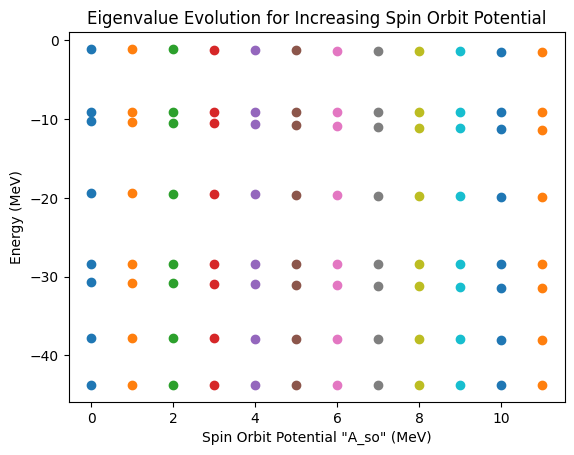

In [15]:
l = 0 #Similar to above steps to find energy eigenvalues but instead loops through increasing Spin Orbit Potentials and plots in a scatter plot to
s = 1/2 #see how the lowest ten values change. The value changes are extremely small are printed out as well to show the the lowest 10 eigenvalues for each A_so value
j = l+s
y = np.arange(0,10)

for i in range(0, 12): #12 is approximately 50/4
  eval2 = []
  A_so = i
  for t in range(0,3):
    A_so = A_so*(10**6)*(1.602*10**-19)
    diag_WS = WoodSaxon(x)
    diag_SO = SpinOrbit(x, i*(10**6)*(1.602*10**-19), t+s, t, s)
    WS_matrix = sparse.diags(diag_WS,0)
    SO_matrix = sparse.diags(diag_SO,0)
    V_matrix = np.add(WS_matrix, SO_matrix)
    H = np.identity(N)*(-(hbar**2/(2*m*Delta**2))*T_matrix + V_matrix)
    H = np.delete(H, 0, 0)
    H = np.delete(H, -1, 0)
    H = np.delete(H, 0, 1)
    H = np.delete(H, -1, 1)
    eval, evec = la.eig(H)

    z4 = np.argsort(eval)
    z4 = z4[0:10]
    #energies4 = (eval[z4]/eval[z4][0])
    energies4 = np.real(eval[z4])

    if Physical_Units == True:
      energies4 = energies4*conv
      eval = eval*conv

    vals = []
    vals = energies4.copy()

    for k in range(len(vals)):
      if vals[k] < 0:
        eval2 = np.append(eval2, vals[k])

  eval2 = np.sort(eval2)
  print(eval2)
  plt.scatter([i]*(len(eval2)), eval2)
plt.title("Eigenvalue Evolution for Increasing Spin Orbit Potential")
plt.xlabel("Spin Orbit Potential \"A_so\" (MeV)")
plt.ylabel("Energy (MeV)")
